# Load Data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [2]:
import os
import sys

INGESTION_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, INGESTION_PATH)

from src import config
from src import preprocessing
from src import plotting


In [3]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date

## Load Data

In [4]:
df = preprocessing.preprocess_and_merge_external_data()

Loading DOHMH data...
Data Shape: (1029643, 26)
Preprocessing DOHMH data...
Data Shape: (618972, 43)
Merging census data...
Data Shape: (618972, 47)
Merging weather data...
Data Shape: (618972, 53)
Final Data Shape: (618972, 53)


### Plot Data

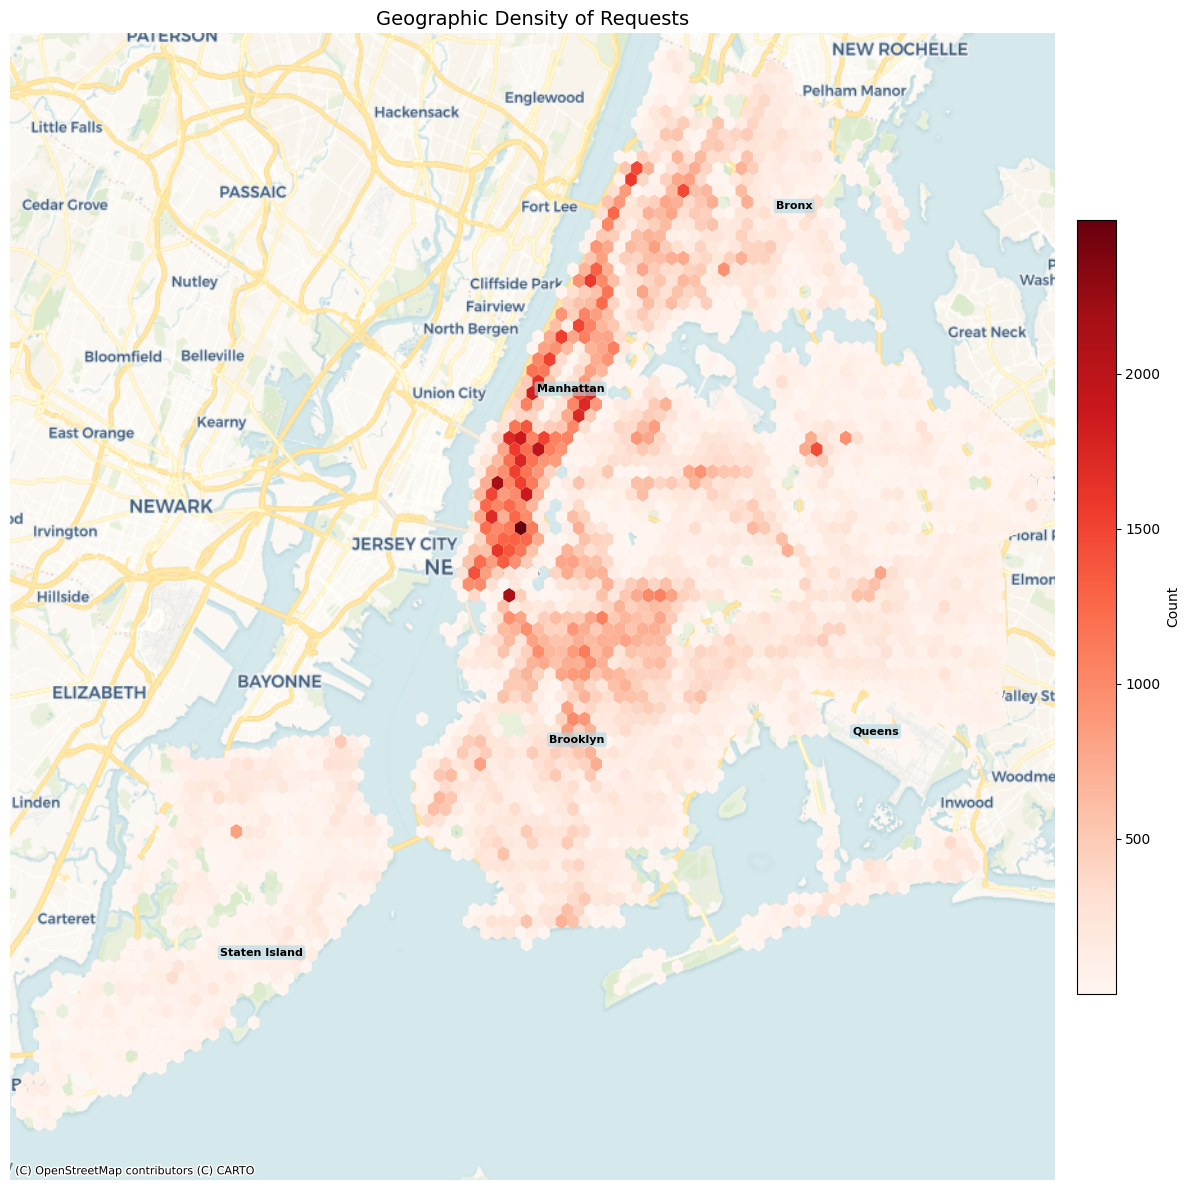

In [6]:
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests",
)
plt.show()


## Merge Census Data

In [ ]:
data_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "acs-population", "combined_population_data.csv"))
df_pop = pd.read_csv(data_path)
df_pop['GEOID'] = df_pop['GEOID'].astype(str)


In [ ]:
bg_shapefile = os.path.abspath(os.path.join(INGESTION_PATH, 'resources', "tl_2022_36_bg"))  # replace with your path
gdf_bg = gpd.read_file(bg_shapefile)

In [ ]:
geometry = [Point(xy) for xy in zip(df_orig.longitude, df_orig.latitude)]
gdf_orig = gpd.GeoDataFrame(df_orig, geometry=geometry, crs="EPSG:4326")

gdf_bg = gdf_bg.to_crs("EPSG:4326")  # make sure CRS matches
gdf_orig_bg = gpd.sjoin(gdf_orig, gdf_bg[['GEOID', 'geometry']], how="left")

df_orig_merged = gdf_orig_bg.merge(df_pop, on=['GEOID', 'year'], how='left')


### Merge Weather Data

In [ ]:
data_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "noaa-nclimgrid-daily", "nyc_fips_weather_data.csv"))
df_weather = pd.read_csv(data_path)
df_weather['fips'] = df_weather['fips'].astype(str)
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date

In [ ]:
df_orig_merged['fips'] = df_orig_merged['GEOID'].apply(lambda x: str(x)[:5])
df_orig_merged = df_orig_merged.merge(df_weather[['fips', 'date', 'tmax', 'tmin', 'tavg', 'prcp']], on = ['fips', 'date'], how = 'left')

In [ ]:
df_weather.groupby(['fips', 'year', 'month'])['month'].count()

In [ ]:
df_orig_merged